# 🎯 Policy Gradient Tutorial: Solving CartPole with REINFORCE Algorithm  

Welcome to this tutorial on **Policy Gradient algorithms**, a fundamental approach in reinforcement learning (RL). This notebook is designed to provide a clear, hands-on guide to implementing and understanding policy gradient methods, specifically applied to the popular **CartPole environment** from OpenAI's Gym. 🚀  

We are going to implement the **REINFORCE algorithm** introduced in the following paper:  
📜 Williams, R.J. *Simple statistical gradient-following algorithms for connectionist reinforcement learning*. *Mach Learn* **8**, 229–256 (1992). [DOI Link](https://doi.org/10.1007/BF00992696)  

---

## 🌟 What You'll Learn  

In this tutorial, you will:  
- 🧠 **Understand** the core principles behind policy gradient algorithms.  
- 💻 **Implement** a policy gradient method from scratch using Python.  
- 🎮 **Train** an agent to balance a pole on a cart in the CartPole environment.  
- 📊 **Gain insights** into the advantages and limitations of policy gradient methods in reinforcement learning.  

Whether you're a beginner in RL or looking to solidify your understanding of policy-based methods, this notebook aims to bridge the gap between theory and practice.  

---

## 👨‍💻 About the Author  

This tutorial was created by **Salar Basiri**, a PhD student specializing in **Control and Optimization** at the **University of Illinois at Urbana-Champaign**. 📚  

Feel free to reach out at:  
📧 **salarbsr.1996 [at] gmail** for feedback, questions, or collaborations!  

---

✨ **Let’s dive in and learn reinforcement learning by solving CartPole!** 🎉


# 🧠 Understanding the REINFORCE Algorithm  

The **REINFORCE algorithm** is a fundamental approach in policy gradient methods for reinforcement learning. It provides a way to optimize policies by estimating the gradient of the expected return with respect to the policy parameters.

---

## 📜 Mathematical Derivation  

Let **τ(1), ..., τ(n)** be *n* empirical trajectory samples obtained by running the policy **πθ** for *n* episodes, each with **T** time steps. The objective is to maximize the expected return, denoted as **η(θ)**:  




$\eta(\theta) = \mathbb{E}_{\tau \sim P_\theta} [f(\tau)]$,


where **f(τ)** is a reward function associated with trajectory **τ**, and **Pθ(τ)** represents the probability of the trajectory under the current policy.

The gradient of **η(θ)** with respect to the policy parameters **θ** can be written as:  

$
\nabla_\theta \eta(\theta) = \nabla_\theta \mathbb{E}_{\tau \sim P_\theta} [f(\tau)] = \mathbb{E}_{\tau \sim P_\theta} [\nabla_\theta \log P_\theta(\tau) \cdot f(\tau)].
$

---

## 🔢 Gradient Estimation  

Using **n** empirical samples from **Pθ**, we estimate the gradient as:

$
\nabla_\theta \eta(\theta) \approx \frac{1}{n} \sum_{i=1}^{n} \nabla_\theta \log P_\theta(\tau^{(i)}) \cdot f(\tau^{(i)}),
$

where:  
- **τ(i)** is the *i-th* trajectory sampled from the policy.  
- **log Pθ(τ(i))** is the log probability of the trajectory under the policy **πθ**.  
- **f(τ(i))** is the return (cumulative reward) for trajectory **τ(i)**.

---

## 🔍 Decomposing Log Probability  

Here, recall that **μ(s₀)** denotes the density of the initial state distribution **s₀**. It follows that:

$\log P_\theta(\tau) = \log \mu(s_0) + \log \pi_\theta(a_0 | s_0) + \log P_{s_0 a_0}(s_1) + \log \pi_\theta(a_1 | s_1) + \log P_{s_1 a_1}(s_2) + \dots + \log P_{s_{T-1} a_{T-1}}(s_T).$

Taking the gradient with respect to θ, we obtain:
$\nabla_\theta \log P_\theta(\tau) = \nabla_\theta \log \pi_\theta(a_0 | s_0) + \nabla_\theta \log \pi_\theta(a_1 | s_1) + \dots + \nabla_\theta \log \pi_\theta(a_{T-1} | s_{T-1}).$

This decomposition emphasizes that only the terms involving the policy πθ depend on the parameter θ, simplifying the computation.

# 🔑 Final Gradient Expression  

Finally, we arrive at the complete expression for the gradient of the expected return **η(θ)**:  


$\nabla_\theta \eta(\theta) = \nabla_\theta \mathbb{E}_{\tau \sim P_\theta} [f(\tau)] = \mathbb{E}_{\tau \sim P_\theta} \left[ \left( \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t | s_t) \right) \cdot f(\tau) \right].$

And we can estimate this expectation by sampling $N$ trajectories and taking the average.

## 🚀 Key Insights  

1. **Policy Gradient Theorem**: The REINFORCE algorithm leverages the relationship between the gradient of the expected return and the gradient of the policy's log-likelihood.  
2. **Empirical Estimation**: The gradient is estimated using trajectories sampled directly from the policy, enabling model-free reinforcement learning.  
3. **Scalability**: While simple and effective, REINFORCE suffers from high variance, often mitigated by techniques such as baseline subtraction.

---

**Let’s proceed to implement the REINFORCE algorithm and apply it to the CartPole environment! 🎉**


## Importing Libraries

In [4]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from datetime import datetime
import time
import keyboard
from torch.utils.tensorboard import SummaryWriter


## Creating the cartpole environment

# 🏋️‍♂️ CartPole Environment Overview

The **CartPole** environment is one of the classic problems used to demonstrate reinforcement learning (RL) algorithms. In this environment, the objective is to balance a pole on a cart by applying forces to the cart, keeping the pole upright for as long as possible. The problem is a typical example of a *control problem* where the agent learns to make decisions to maintain stability in a dynamic system.

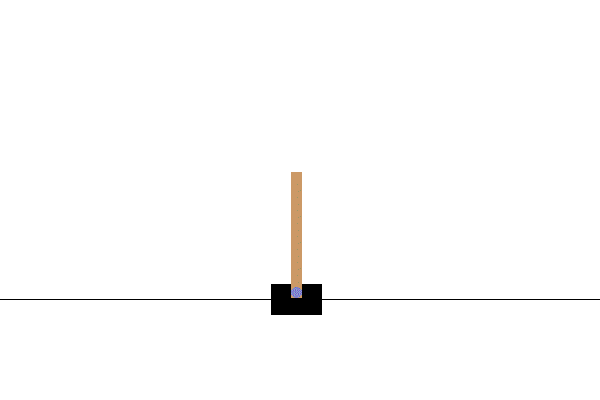

## 🌟 Key Elements of the CartPole Problem

- **Cart**: The cart moves horizontally along a straight track. It can be controlled by applying forces to the left or right.
- **Pole**: The pole is attached to the cart by a hinge and starts in an upright position. The agent's goal is to keep the pole balanced vertically.
- **State Space**: The state space consists of the following four values:
  1. **Cart Position**: The position of the cart on the track.
  2. **Cart Velocity**: The velocity of the cart.
  3. **Pole Angle**: The angle of the pole from the vertical position.
  4. **Pole Velocity at Tip**: The velocity of the tip of the pole.

- **Action Space**: The action space consists of two possible actions:
  1. **Move Left**: Apply a force to move the cart to the left.
  2. **Move Right**: Apply a force to move the cart to the right.

- **Reward**: The agent receives a reward of +1 for each time step that the pole remains balanced (i.e., stays upright).

- **Termination Condition**: The episode terminates when:
  1. The pole angle exceeds a certain threshold (usually ±15 degrees).
  2. The cart moves too far from the center of the track (usually beyond ±2.4 units).
  3. The maximum number of time steps is reached (typically 500 steps).

---

## ⚙️ Environment Dynamics

The environment is designed to simulate a dynamic system where the actions taken by the agent affect the state of the system over time. The agent learns how to balance the pole by adjusting its actions based on the state feedback (cart position, pole angle, etc.).

---

## 💡 Why CartPole?

The CartPole environment is widely used in reinforcement learning as a benchmark for evaluating and comparing different algorithms, especially those based on **policy gradients**. It’s simple yet rich enough to test the effectiveness of RL models in control tasks.

Let's dive deeper into solving this problem using the REINFORCE algorithm! 🚀


In [2]:
env_name = 'CartPole-v1'
env = gym.make(env_name)  # CartPole has continuous states, discrete actions
env.reset(seed=42)

(array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32),
 {})

## Creating the policy network

Here we only use a simple FC Neural Network to represent our policy given a state. The output of this network is a probability distribution over all possible actions.

In [5]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

Now we need to write down the code that trains the network by implementing REINFORCE Algorithm introduced above. Here T is the horizon, N is the number of trajectories sampled to estimate the gradient expectation, and gamma is the discount factor. The parameter lr specifies the learning rate of the gradient descent.

In [6]:
def train(policy_net, env, writer, baseline = 'None', num_episodes=1000, T=200, N=10, gamma=0.99, lr=0.01):
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    
    for episode in tqdm(range(num_episodes),colour='green'):
        trajectories = []

        # Step 1: Sample N trajectories
        for _ in range(N):
            state, _ = env.reset()
            trajectory = []
            total_reward = 0
            done = False
            t = 0
            
            while not done and t < T:
                # Get action probabilities from the policy network
                state_tensor = torch.tensor(state, dtype=torch.float32)
                action_probs = policy_net(state_tensor)
                
                # Sample action based on probabilities
                action = np.random.choice(len(action_probs), p=action_probs.detach().numpy())
                
                # Take action in the environment
                next_state, reward, done, _, _ = env.step(action)
                trajectory.append((state, action, reward))
                total_reward += reward
                
                state = next_state
                t += 1

            # Store trajectory
            trajectories.append((trajectory, total_reward))
        avg_reward = np.mean([total_reward for _, total_reward in trajectories])
        
        writer.add_scalar('Mean Rewards', avg_reward, episode)
        # Step 2: Calculate the total reward and discounted rewards for each trajectory
        rewards_to_go = []
        for trajectory, _ in trajectories:
            discounted_rewards = []
            cumulative_reward = 0
            t = 0
            # Calculate the discounted reward for each step in the trajectory
            for (_, _, reward) in trajectory:
                cumulative_reward = reward  +  cumulative_reward
                discounted_rewards.insert(0, cumulative_reward)
                t += 1
            rewards_to_go.append(discounted_rewards)

        # Step 3: Compute gradients for policy updates
        policy_loss = 0
        for i, (trajectory, trajectory_reward) in enumerate(trajectories):
            log_grad_sum = 0  # Accumulate log gradients for each trajectory

            # For each timestep in the trajectory
            for t, (state, action, _) in enumerate(trajectory):
                # Convert state to tensor and get action probabilities
                state_tensor = torch.tensor(state, dtype=torch.float32)
                action_probs = policy_net(state_tensor)
                
                # Calculate log probability of the chosen action
                log_prob = torch.log(action_probs[action])
                
                # choosing the baseline value
                alpha = 0.9
                base_value = alpha*avg_reward + (1-alpha)*trajectory_reward
                # Accumulate gradient of log probability
                log_grad_sum += -log_prob * (rewards_to_go[i][0]-base_value)

            # Multiply by the discounted total reward of the trajectory
            
            policy_loss += log_grad_sum 

        # Step 4: Update the policy network
        policy_loss = policy_loss/len(trajectories)
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # Optional: Print progress
        if episode % 50 == 0:
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")



The function below runs the simulation of the cartpole based on a given policy network "policy_net".

In [8]:

def run_cartpole_simulation(policy_net):
    env = gym.make('CartPole-v1', render_mode='human')
    state, _ = env.reset()
    done = False
    total_reward = 0

    print("Press 'q' to stop the simulation.")

    try:
        while not done:
            # Check if 'q' is pressed to stop the simulation
            if keyboard.is_pressed('q'):
                print("Simulation interrupted by user.")
                break

            # Convert state to tensor and get action probabilities
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy_net(state_tensor)

            # Choose action with the highest probability
            action = np.argmax(action_probs.detach().numpy())

            # Take action in environment
            state, reward, done, _, _ = env.step(action)
            total_reward += reward

        # Keep the window open briefly after the simulation ends
        time.sleep(2)
    except KeyboardInterrupt:
        print("Simulation stopped by KeyboardInterrupt.")
    finally:
        env.close()
        print(f"Total Reward: {total_reward}")

Here We set up the parameters and run the training loop!

In [ ]:
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
learning_rate = 0.1
gamma = 0.98  # Discount factor
N = 10  # Number of trajectories per update
T = 200  # Maximum steps per trajectory
policy_net = PolicyNetwork(input_dim, output_dim)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
run_name = 'runs/' + env_name +'/ANN/'+datetime.now().strftime(("%Y_%m_%d %H_%M_%S"))
writer = SummaryWriter(log_dir=run_name)
train(policy_net, env, writer, num_episodes=500, T=500, N=10, gamma=0.99, lr=0.001)
writer.close()

  0%|          | 1/500 [00:00<01:08,  7.30it/s]

Episode 0, Average Reward: 22.40


 10%|█         | 51/500 [00:06<01:23,  5.41it/s]

Episode 50, Average Reward: 57.70


 20%|██        | 101/500 [00:18<01:50,  3.60it/s]

Episode 100, Average Reward: 72.30


 30%|███       | 151/500 [00:49<05:26,  1.07it/s]

Episode 150, Average Reward: 294.00


 40%|████      | 201/500 [01:59<08:02,  1.61s/it]

Episode 200, Average Reward: 434.80


 50%|█████     | 251/500 [03:25<07:21,  1.77s/it]

Episode 250, Average Reward: 500.00


 60%|██████    | 301/500 [04:54<05:59,  1.81s/it]

Episode 300, Average Reward: 485.80


 70%|███████   | 351/500 [06:26<04:32,  1.83s/it]

Episode 350, Average Reward: 500.00


 80%|████████  | 401/500 [08:00<03:04,  1.86s/it]

Episode 400, Average Reward: 500.00


 90%|█████████ | 451/500 [09:33<01:32,  1.89s/it]

Episode 450, Average Reward: 500.00


100%|██████████| 500/500 [11:08<00:00,  1.34s/it]


And finally, we can see how well our policy is trained!!!

In [10]:
run_cartpole_simulation(policy_net)

Press 'q' to stop the simulation.
Total Reward: 1090.0


To visualize the training, we use Tensorboard. you only need to open up a command shell and type:

tensorboard --logdir=[where you have stored the log files]